# Fine-tuning XLM-RoBERTa for NER

## Overview
This notebook fine-tunes a multilingual transformer model on the LitBank dataset.

**Content**
1. Load preprocessed data from Notebook 1
2. Configure XLM-RoBERTa for token classification
3. Handle subword tokenization (critical for transformers)
4. Train using Hugging Face Trainer
5. Evaluate on English test set
6. Visualize results (F1 scores, confusion matrix, training curves)

**Model: XLM-RoBERTa**
- Multilingual (Pre-trained on 100 languages)
- State-of-the-art performance on sequence labeling
- Enables cross-lingual transfer

In [1]:
# Import required libraries
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Tuple
from tqdm.auto import tqdm

# Hugging Face Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification
)
from datasets import Dataset

# Evaluation metrics
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported")

✓ Libraries imported


In [2]:
# Configure paths
PROCESSED_DATA_PATH = Path("../data/processed")
MODEL_OUTPUT_PATH = Path("../models")
RESULTS_PATH = Path("../results")

MODEL_OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

# Model configuration
MODEL_NAME = "xlm-roberta-base"  # Multilingual model
MAX_LENGTH = 512  # Maximum sequence length (tokens)
BATCH_SIZE = 16   # Adjust based on your GPU memory (8/16/32)
LEARNING_RATE = 2e-5  # Standard for fine-tuning transformers
NUM_EPOCHS = 3    # Typically 3-5 epochs for NER

print(f"✓ Configuration loaded")
print(f"  Model: {MODEL_NAME}")
print(f"  Max length: {MAX_LENGTH} tokens")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")

✓ Configuration loaded
  Model: xlm-roberta-base
  Max length: 512 tokens
  Batch size: 16
  Learning rate: 2e-05
  Epochs: 3


## 1. Load Preprocessed Data

Load the JSON files created in Notebook 1.

In [3]:
def load_processed_data(data_path: Path) -> Tuple[Dict, Dataset, Dataset, Dataset]:
    """
    Load preprocessed JSON data and convert to Hugging Face Dataset format.
    
    WHY: Hugging Face's Dataset class provides efficient batching and caching.
    
    Returns:
        label_mapping: {"label2id": {...}, "id2label": {...}}
        train_dataset: Training examples
        dev_dataset: Validation examples
        test_dataset: Test examples
    """
    # Load label mapping
    with open(data_path / "label_mapping.json", 'r', encoding='utf-8') as f:
        label_mapping = json.load(f)
    
    # Load datasets
    with open(data_path / "train_data.json", 'r', encoding='utf-8') as f:
        train_data = json.load(f)
    
    with open(data_path / "dev_data.json", 'r', encoding='utf-8') as f:
        dev_data = json.load(f)
    
    with open(data_path / "test_data.json", 'r', encoding='utf-8') as f:
        test_data = json.load(f)
    
    # Convert to Hugging Face Dataset format
    train_dataset = Dataset.from_list(train_data)
    dev_dataset = Dataset.from_list(dev_data)
    test_dataset = Dataset.from_list(test_data)
    
    print(f"✓ Loaded preprocessed data from {data_path}")
    print(f"  Train: {len(train_dataset)} examples")
    print(f"  Dev:   {len(dev_dataset)} examples")
    print(f"  Test:  {len(test_dataset)} examples")
    print(f"  Labels: {len(label_mapping['label2id'])} unique tags")
    
    return label_mapping, train_dataset, dev_dataset, test_dataset


# Load data
label_mapping, train_dataset, dev_dataset, test_dataset = load_processed_data(PROCESSED_DATA_PATH)

# Convert string keys to integers for model
id2label = {int(k): v for k, v in label_mapping["id2label"].items()}
label2id = label_mapping["label2id"]

print(f"\nLabel mapping preview:")
for idx in sorted(id2label.keys())[:10]:
    print(f"  {idx}: {id2label[idx]}")

✓ Loaded preprocessed data from ../data/processed
  Train: 5577 examples
  Dev:   747 examples
  Test:  693 examples
  Labels: 13 unique tags

Label mapping preview:
  0: O
  1: B-FAC
  2: B-GPE
  3: B-LOC
  4: B-ORG
  5: B-PER
  6: B-VEH
  7: I-FAC
  8: I-GPE
  9: I-LOC


## 2. Tokenization and Label Alignment

Transformers use subword tokenization (WordPiece/BPE), while labels correspond to words. Which subwords get the label?

**First-token strategy** : the first subword receives the label, subsequent tokens will be ignored (the `-100` label tells PyTorch to ignore these tokens when computing loss.)

In [4]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"✓ Loaded tokenizer: {MODEL_NAME}")

# Example: Show subword tokenization
example_text = "Elizabeth Bennet lived in Pemberley in the lake district of northern England."
tokens = tokenizer.tokenize(example_text)
print(f"\nExample tokenization:")
print(f"  Input:  {example_text}")
print(f"  Tokens: {tokens}")

✓ Loaded tokenizer: xlm-roberta-base

Example tokenization:
  Input:  Elizabeth Bennet lived in Pemberley in the lake district of northern England.
  Tokens: ['▁Elizabeth', '▁Ben', 'net', '▁lived', '▁in', '▁Pembe', 'r', 'ley', '▁in', '▁the', '▁lake', '▁district', '▁of', '▁north', 'ern', '▁England', '.']


In [5]:
def tokenize_and_align_labels(examples: Dict) -> Dict:
    """
    Tokenize input and align NER labels with subword tokens.
    
    WHY: This is the most critical function for NER with transformers!
    Without proper alignment, your model will learn incorrect labels.
    
    Process:
    1. Tokenize words into subwords
    2. For each subword, determine which original word it came from
    3. Assign labels:
       - First subword of word → original label
       - Continuation subwords → -100 (ignored)
       - Special tokens ([CLS], [SEP]) → -100 (ignored)
    
    Args:
        examples: Batch of examples with "tokens" and "ner_tags"
        
    Returns:
        Tokenized inputs with aligned labels
    """
    # Tokenize all examples
    # is_split_into_words=True tells tokenizer we already have word tokens
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        max_length=MAX_LENGTH,
        is_split_into_words=True,
        padding=False  # We'll pad dynamically in batches
    )
    
    all_labels = []
    
    # Process each example in the batch
    for i, labels in enumerate(examples["ner_tags"]):
        # word_ids() returns which original word each token came from
        # Example: [None, 0, 1, 1, 2, None] means:
        #   - Token 0: special token ([CLS])
        #   - Token 1: from word 0
        #   - Token 2-3: from word 1 (subwords!)
        #   - Token 4: from word 2
        #   - Token 5: special token ([SEP])
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        
        previous_word_idx = None
        label_ids = []
        
        for word_idx in word_ids:
            # Special tokens (None) → -100
            if word_idx is None:
                label_ids.append(-100)
            
            # First subword of a word → original label
            elif word_idx != previous_word_idx:
                label_ids.append(labels[word_idx])
            
            # Continuation subwords → -100
            else:
                label_ids.append(-100)
            
            previous_word_idx = word_idx
        
        all_labels.append(label_ids)
    
    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs


print("✓ Tokenization function defined")

✓ Tokenization function defined


In [6]:
# Apply tokenization to all datasets
print("Tokenizing datasets...")

tokenized_train = train_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=train_dataset.column_names,
    desc="Tokenizing training data"
)

tokenized_dev = dev_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dev_dataset.column_names,
    desc="Tokenizing dev data"
)

tokenized_test = test_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=test_dataset.column_names,
    desc="Tokenizing test data"
)

print("\n✓ Tokenization complete!")
print(f"\nExample tokenized input:")
example = tokenized_train[0]
print(f"  Input IDs shape: {len(example['input_ids'])}")
print(f"  Labels shape:    {len(example['labels'])}")
print(f"  First 10 tokens: {tokenizer.convert_ids_to_tokens(example['input_ids'][:10])}")
print(f"  First 10 labels: {example['labels'][:10]}")

Tokenizing datasets...


Tokenizing training data:   0%|          | 0/5577 [00:00<?, ? examples/s]

Tokenizing dev data:   0%|          | 0/747 [00:00<?, ? examples/s]

Tokenizing test data:   0%|          | 0/693 [00:00<?, ? examples/s]


✓ Tokenization complete!

Example tokenized input:
  Input IDs shape: 25
  Labels shape:    25
  First 10 tokens: ['<s>', '▁CHA', 'P', 'TER', '▁1', '▁', '.', '▁A', '▁Not', '▁Un']
  First 10 labels: [-100, 0, -100, -100, 0, 0, -100, 0, 0, 0]


## 3. Load Model

Load XLM-RoBERTa and add a token classification head on top.

In [7]:
# Load pre-trained model
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True  # Since we're adding a new classification head
)

print(f"✓ Loaded model: {MODEL_NAME}")
print(f"  Parameters: {model.num_parameters():,}")
print(f"  Output labels: {model.num_labels}")
print(f"\nModel architecture:")
print(f"  1. XLM-RoBERTa encoder (pre-trained on 100 languages)")
print(f"  2. Token classification head (randomly initialized, will be trained)")

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Loaded model: xlm-roberta-base
  Parameters: 277,463,053
  Output labels: 13

Model architecture:
  1. XLM-RoBERTa encoder (pre-trained on 100 languages)
  2. Token classification head (randomly initialized, will be trained)


## 4. Define Evaluation Metrics

**Seqeval**
- Standard NER evaluation library
- Computes entity-level F1 (not token-level)

**Metrics:**
- **Precision**: Of predicted entities, how many were correct?
- **Recall**: Of true entities, how many were found?
- **F1**: Harmonic mean of precision and recall

In [8]:
def compute_metrics(pred):
    """
    Compute evaluation metrics during training.
    
    WHY: This function is called by Trainer after each evaluation.
    It converts model predictions back to BIO tags and computes F1.
    
    Args:
        pred: Predictions object with logits and labels
        
    Returns:
        Dictionary with precision, recall, f1, accuracy
    """
    predictions, labels = pred
    
    # Get predicted class for each token (argmax over logits)
    predictions = np.argmax(predictions, axis=2)
    
    # Convert to BIO tag strings (removing -100 labels)
    true_labels = []
    true_predictions = []
    
    for prediction, label in zip(predictions, labels):
        true_label = []
        true_pred = []
        
        for pred_id, label_id in zip(prediction, label):
            # Skip -100 labels (subwords and special tokens)
            if label_id != -100:
                true_label.append(id2label[label_id])
                true_pred.append(id2label[pred_id])
        
        true_labels.append(true_label)
        true_predictions.append(true_pred)
    
    # Compute entity-level metrics using seqeval
    results = {
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions),
    }
    
    return results


print("✓ Evaluation metrics defined")

✓ Evaluation metrics defined


## 5. Training Configuration

**Key hyperparameters**
- **Learning rate**: How big the update steps are (2e-5 is standard for fine-tuning)
- **Batch size**: Number of examples processed together (larger = faster but more memory)
- **Epochs**: Full passes through training data (3-5 typical for NER)
- **Warmup**: Gradually increase learning rate at start (stabilizes training)
- **Weight decay**: Regularization to prevent overfitting

In [9]:
# Define training arguments
training_args = TrainingArguments(
    output_dir=str(MODEL_OUTPUT_PATH / "checkpoints"),
    
    # Training hyperparameters
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,  # L2 regularization
    
    # Evaluation and logging
    eval_strategy="epoch",  # Evaluate after each epoch
    save_strategy="epoch",  # Save checkpoint after each epoch
    logging_steps=100,      # Log every 100 steps
    load_best_model_at_end=True,  # Load best checkpoint at end
    metric_for_best_model="f1",    # Use F1 to select best model
    
    # Performance optimizations
    fp16=False,  # Set to True if you have a GPU with FP16 support
    dataloader_num_workers=0,  # Increase if you have multiple CPU cores
    
    # Reporting
    report_to="none",  # Disable wandb/tensorboard (can enable if desired)
    
    # Other settings
    push_to_hub=False,
    seed=42,  # For reproducibility
)

# Data collator (handles dynamic padding)
data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer,
    padding=True  # Pad to longest sequence in batch
)

print("✓ Training configuration ready")
print(f"\nTotal training steps: ~{len(tokenized_train) // BATCH_SIZE * NUM_EPOCHS}")
print(f"Evaluation: After each epoch")
print(f"Best model selected by: F1 score")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


✓ Training configuration ready

Total training steps: ~1044
Evaluation: After each epoch
Best model selected by: F1 score


## 6. Train the Model

**Training loop**
1. Model reads tokenized text
2. Predicts label probabilities for each token
3. Compares predictions to true labels (cross-entropy loss)
4. Updates weights via backpropagation
5. Repeats for all batches (1 epoch)
6. Evaluates on dev set
7. Repeats for NUM_EPOCHS

In [10]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_dev,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("✓ Trainer initialized")

✓ Trainer initialized


In [11]:
# Train!
train_result = trainer.train()

print("\nTRAINING COMPLETE!")
print(f"\nTraining metrics:")
print(f"  Total training time: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"  Training loss: {train_result.metrics['train_loss']:.4f}")

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.268700,0.213598,0.649740,0.719539,0.682860
2,0.186700,0.207407,0.646471,0.746215,0.692771
3,0.145200,0.201709,0.671885,0.742610,0.705479



TRAINING COMPLETE!

Training metrics:
  Total training time: 75.12 seconds
  Training loss: 0.2506


## 7. Save the Model

Save the best model for use in Notebook 3 (evaluation).

In [12]:
# Save model and tokenizer
final_model_path = MODEL_OUTPUT_PATH / "litbank-xlm-roberta"
trainer.save_model(str(final_model_path))
tokenizer.save_pretrained(str(final_model_path))

print(f"✓ Model saved to: {final_model_path.absolute()}")
print("\nSaved files:")
for file in final_model_path.iterdir():
    print(f"  - {file.name}")

✓ Model saved to: /storage/homefs/nw03x063/CAS_Mod4_NER/notebooks/../models/litbank-xlm-roberta

Saved files:
  - model.safetensors
  - config.json
  - training_args.bin
  - tokenizer_config.json
  - special_tokens_map.json
  - tokenizer.json


## 8. Evaluate on Test Set

Evaluate on the (previously unseen) test set.

In [13]:
# Evaluate on test set
print("Evaluating on test set...")
test_results = trainer.evaluate(eval_dataset=tokenized_test)

print("\nTEST SET RESULTS (English Literary Text)")
print(f"\nOverall metrics:")
print(f"  Precision: {test_results['eval_precision']:.4f}")
print(f"  Recall:    {test_results['eval_recall']:.4f}")
print(f"  F1 Score:  {test_results['eval_f1']:.4f}")

Evaluating on test set...



TEST SET RESULTS (English Literary Text)

Overall metrics:
  Precision: 0.6466
  Recall:    0.6935
  F1 Score:  0.6693


## 9. Per-Entity Type Evaluation

Model performs on each entity type (PER, LOC, etc.).

In [14]:
def get_detailed_predictions(trainer, dataset, original_dataset):
    """
    Get predictions and convert back to BIO tags for detailed analysis.
    
    Returns:
        true_labels: List of label sequences
        predictions: List of prediction sequences
    """
    # Get predictions
    pred_output = trainer.predict(dataset)
    predictions = np.argmax(pred_output.predictions, axis=2)
    
    true_labels = []
    true_predictions = []
    
    # Convert to BIO tags
    for i, (prediction, label) in enumerate(zip(predictions, pred_output.label_ids)):
        true_label = []
        true_pred = []
        
        for pred_id, label_id in zip(prediction, label):
            if label_id != -100:
                true_label.append(id2label[label_id])
                true_pred.append(id2label[pred_id])
        
        true_labels.append(true_label)
        true_predictions.append(true_pred)
    
    return true_labels, true_predictions


# Get detailed predictions
print("Generating detailed predictions...")
true_labels, predictions = get_detailed_predictions(trainer, tokenized_test, test_dataset)

# Print classification report (per-entity metrics - AGGREGATED)
print("\n" + "="*60)
print("PER-ENTITY TYPE PERFORMANCE (Aggregated)")
print("="*60)
print(classification_report(true_labels, predictions, digits=4))

# Save aggregated report
report_text = classification_report(true_labels, predictions, digits=4)
with open(RESULTS_PATH / "test_classification_report_aggregated.txt", 'w') as f:
    f.write("Test Set Classification Report (Aggregated)\n")
    f.write("=" * 60 + "\n\n")
    f.write(report_text)

print(f"\n✓ Saved aggregated report to {RESULTS_PATH / 'test_classification_report_aggregated.txt'}")

# Print DETAILED classification report (per-tag including B- and I- separately)
print("\n" + "="*60)
print("DETAILED PER-TAG PERFORMANCE (B- and I- tags)")
print("="*60)

# Flatten the nested lists for sklearn's classification_report
flat_true_labels = [label for seq in true_labels for label in seq]
flat_predictions = [label for seq in predictions for label in seq]

# Use sklearn's classification_report to show each tag separately
from sklearn.metrics import classification_report as sklearn_classification_report

detailed_report = sklearn_classification_report(
    flat_true_labels, 
    flat_predictions, 
    digits=4,
    zero_division=0
)
print(detailed_report)

# Save detailed report
with open(RESULTS_PATH / "test_classification_report_detailed.txt", 'w') as f:
    f.write("Test Set Classification Report (Detailed: B- and I- tags)\n")
    f.write("=" * 60 + "\n\n")
    f.write(detailed_report)

print(f"✓ Saved detailed report to {RESULTS_PATH / 'test_classification_report_detailed.txt'}")

Generating detailed predictions...

PER-ENTITY TYPE PERFORMANCE (Aggregated)
              precision    recall  f1-score   support

         FAC     0.5323    0.5544    0.5431       193
         GPE     0.5465    0.7833    0.6438        60
         LOC     0.5043    0.5321    0.5179       109
         ORG     0.0000    0.0000    0.0000         6
         PER     0.7010    0.7477    0.7236       856
         VEH     0.5333    0.5000    0.5161        16

   micro avg     0.6466    0.6935    0.6693      1240
   macro avg     0.4696    0.5196    0.4908      1240
weighted avg     0.6444    0.6935    0.6674      1240


✓ Saved aggregated report to ../results/test_classification_report_aggregated.txt

DETAILED PER-TAG PERFORMANCE (B- and I- tags)
              precision    recall  f1-score   support

       B-FAC     0.6897    0.7362    0.7122       163
       B-GPE     0.5802    0.7833    0.6667        60
       B-LOC     0.6505    0.6262    0.6381       107
       B-ORG     0.0000    0.0000

## 10. Confusion Matrix

Shows which entity types the model confuses:
- Diagonal = correct predictions
- Off-diagonal = errors

✓ Saved confusion matrix to ../results/confusion_matrix.png


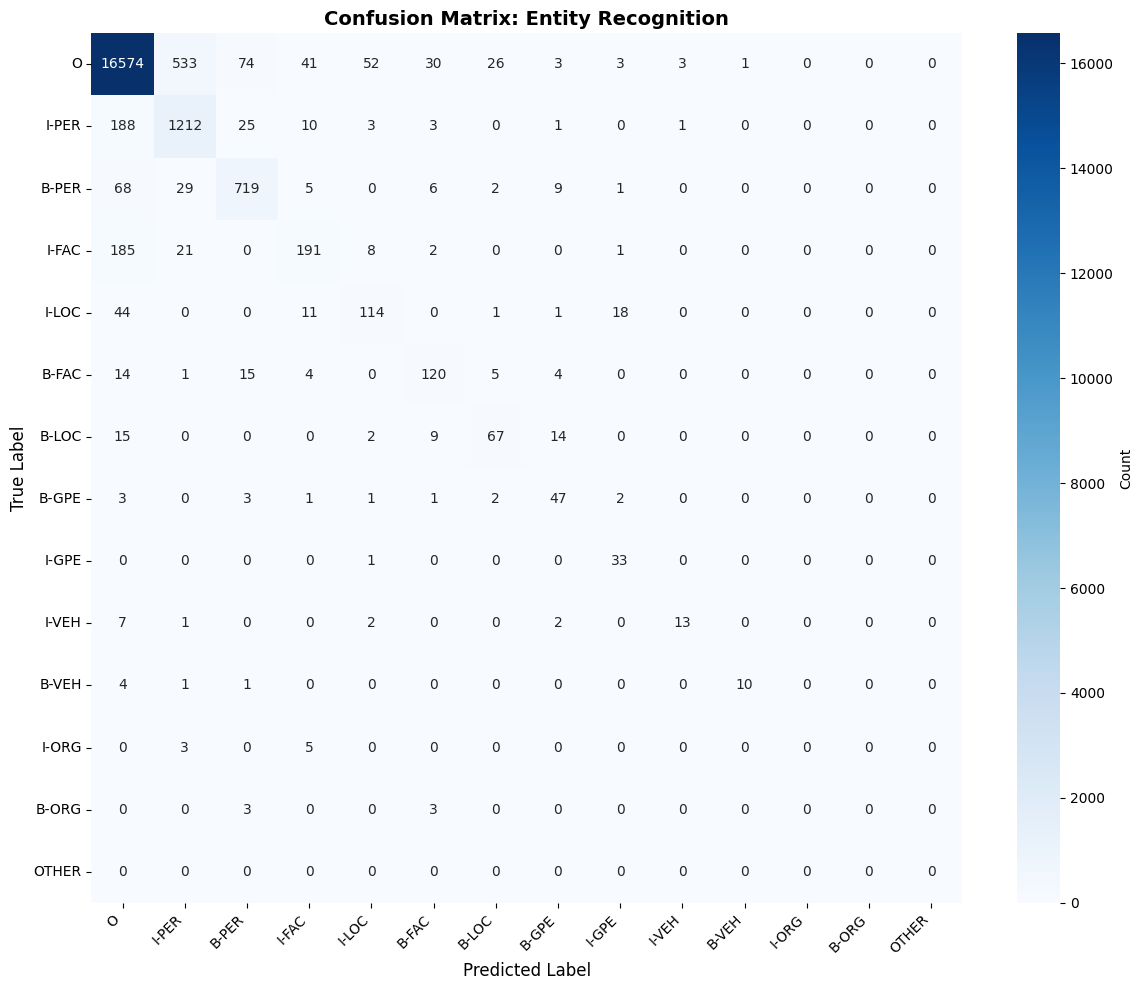

In [15]:
def plot_confusion_matrix(true_labels: List[List[str]], 
                         predictions: List[List[str]], 
                         save_path: Path = None):
    """
    Create confusion matrix for entity types (B- tags only).
    
    WHY: Focus on entity types (PER, LOC, etc.) rather than BIO positions.
    """
    # Flatten lists and extract entity types
    flat_true = []
    flat_pred = []
    
    for true_seq, pred_seq in zip(true_labels, predictions):
        flat_true.extend(true_seq)
        flat_pred.extend(pred_seq)
    
    # Get unique labels (sorted)
    unique_labels = sorted(set(flat_true + flat_pred))
    
    # For readability, focus on entity types (B- and I- separately)
    # Or just top N most common labels
    from collections import Counter
    label_counts = Counter(flat_true)
    top_labels = [label for label, _ in label_counts.most_common(15)]  # Top 15 labels
    
    # Filter predictions and labels
    filtered_true = [l if l in top_labels else 'OTHER' for l in flat_true]
    filtered_pred = [l if l in top_labels else 'OTHER' for l in flat_pred]
    
    # Create confusion matrix
    cm = confusion_matrix(filtered_true, filtered_pred, labels=top_labels + ['OTHER'])
    
    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=top_labels + ['OTHER'],
        yticklabels=top_labels + ['OTHER'],
        cbar_kws={'label': 'Count'}
    )
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Confusion Matrix: Entity Recognition', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved confusion matrix to {save_path}")
    
    plt.show()


# Create confusion matrix
plot_confusion_matrix(
    true_labels, 
    predictions,
    save_path=RESULTS_PATH / "confusion_matrix.png"
)

## 11. Training Curves

Visualize learning progress over time.

✓ Saved training curves to ../results/training_curves.png


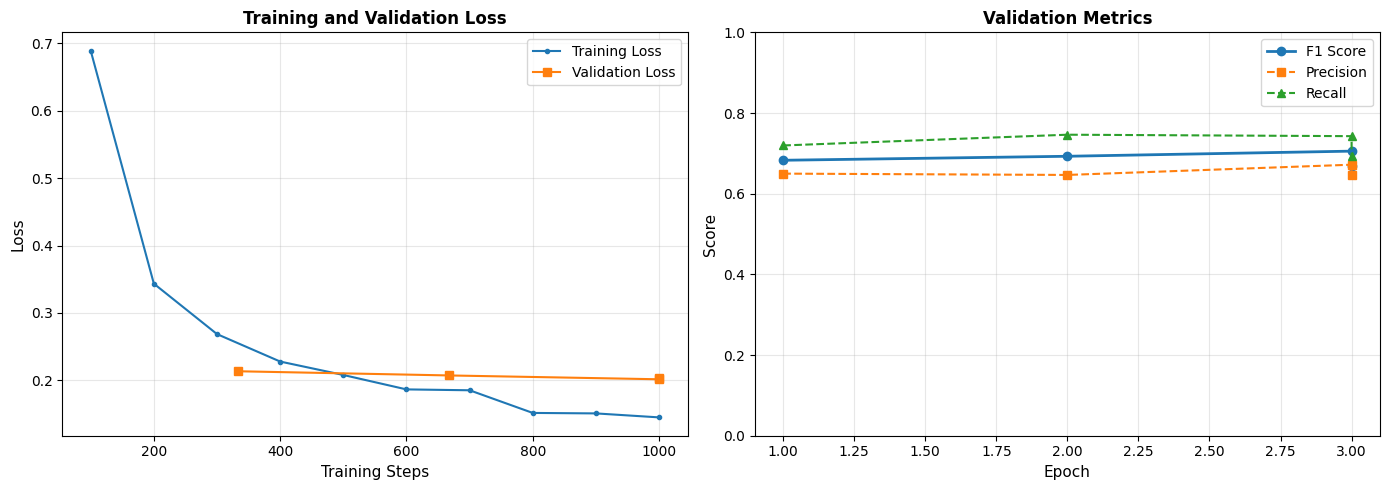

In [16]:
def plot_training_curves(trainer, save_path: Path = None):
    """
    Plot training and validation metrics over epochs.
    
    WHY: Helps diagnose:
    - Overfitting (train improves, val plateaus)
    - Underfitting (both metrics poor)
    - Convergence (metrics stabilize)
    """
    # Extract metrics from log history
    log_history = trainer.state.log_history
    
    # Separate training and evaluation logs
    train_logs = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]
    eval_logs = [log for log in log_history if 'eval_loss' in log]
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Loss curves
    if train_logs and eval_logs:
        train_steps = [log['step'] for log in train_logs if 'loss' in log]
        train_loss = [log['loss'] for log in train_logs if 'loss' in log]
        
        eval_epochs = [log['epoch'] for log in eval_logs]
        eval_loss = [log['eval_loss'] for log in eval_logs]
        
        axes[0].plot(train_steps, train_loss, label='Training Loss', marker='o', markersize=3)
        # Align eval_loss with train steps (approximate)
        if train_steps and eval_epochs:
            steps_per_epoch = max(train_steps) / max(eval_epochs) if eval_epochs else 1
            eval_steps = [epoch * steps_per_epoch for epoch in eval_epochs]
            axes[0].plot(eval_steps, eval_loss, label='Validation Loss', marker='s', markersize=6)
        
        axes[0].set_xlabel('Training Steps', fontsize=11)
        axes[0].set_ylabel('Loss', fontsize=11)
        axes[0].set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
        axes[0].legend()
        axes[0].grid(alpha=0.3)
    
    # Plot 2: F1 Score progression
    if eval_logs:
        eval_epochs = [log['epoch'] for log in eval_logs]
        eval_f1 = [log.get('eval_f1', 0) for log in eval_logs]
        eval_precision = [log.get('eval_precision', 0) for log in eval_logs]
        eval_recall = [log.get('eval_recall', 0) for log in eval_logs]
        
        axes[1].plot(eval_epochs, eval_f1, label='F1 Score', marker='o', linewidth=2)
        axes[1].plot(eval_epochs, eval_precision, label='Precision', marker='s', linestyle='--')
        axes[1].plot(eval_epochs, eval_recall, label='Recall', marker='^', linestyle='--')
        
        axes[1].set_xlabel('Epoch', fontsize=11)
        axes[1].set_ylabel('Score', fontsize=11)
        axes[1].set_title('Validation Metrics', fontsize=12, fontweight='bold')
        axes[1].legend()
        axes[1].grid(alpha=0.3)
        axes[1].set_ylim([0, 1])
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved training curves to {save_path}")
    
    plt.show()


# Plot training curves
plot_training_curves(
    trainer,
    save_path=RESULTS_PATH / "training_curves.png"
)

## 12. Example Predictions

Visualize some predictions to understand model behavior.

In [17]:
def show_predictions(tokens: List[str], true_labels: List[str], predictions: List[str], num_examples: int = 3):
    """
    Display predictions with color-coded entities.
    """
    print("\nEXAMPLE PREDICTIONS")
    
    for i in range(min(num_examples, len(tokens))):
        print(f"\nExample {i+1}:")
        print("-" * 80)
        
        token_seq = tokens[i]
        true_seq = true_labels[i]
        pred_seq = predictions[i]
        
        # Display first 50 tokens
        display_len = min(50, len(token_seq))
        
        for j in range(display_len):
            token = token_seq[j]
            true_label = true_seq[j]
            pred_label = pred_seq[j]
            
            # Mark correct/incorrect
            marker = "✓" if true_label == pred_label else "✗"
            
            if true_label != 'O' or pred_label != 'O':
                print(f"  {token:20s} | True: {true_label:12s} | Pred: {pred_label:12s} {marker}")
        
        if len(token_seq) > display_len:
            print(f"  ... ({len(token_seq) - display_len} more tokens)")


# Show examples
show_predictions(
    [ex['tokens'] for ex in test_dataset],
    true_labels,
    predictions,
    num_examples=3
)


EXAMPLE PREDICTIONS

Example 1:
--------------------------------------------------------------------------------
  Chancery             | True: B-FAC        | Pred: B-GPE        ✗
  London               | True: B-GPE        | Pred: I-GPE        ✗
  Michaelmas           | True: O            | Pred: B-PER        ✗
  the                  | True: O            | Pred: B-PER        ✗
  Lord                 | True: B-PER        | Pred: I-PER        ✗
  Chancellor           | True: I-PER        | Pred: I-PER        ✓
  Lincoln              | True: B-FAC        | Pred: B-PER        ✗
  's                   | True: I-FAC        | Pred: I-FAC        ✓
  Inn                  | True: I-FAC        | Pred: I-FAC        ✓
  Hall                 | True: I-FAC        | Pred: I-FAC        ✓

Example 2:
--------------------------------------------------------------------------------
  the                  | True: B-FAC        | Pred: B-FAC        ✓
  streets              | True: I-FAC        | Pred: I-FA

## Summary

**Files created:**
- `models/litbank-xlm-roberta/` - Fine-tuned model
- `results/test_classification_report.txt` - Detailed metrics
- `results/confusion_matrix.png` - Error analysis
- `results/training_curves.png` - Learning progression

**Next steps:**
Proceed to **Notebook 3: Multilingual Evaluation** to test cross-lingual transfer!